## Описание проекта

Интернет-магазин «Викишоп» представляет новый сервис, который позволяет пользователям вносить изменения в описания товаров, как в вики-сообществах, и обсуждать эти изменения с другими пользователями. Для обеспечения безопасности и качества контента, магазин ищет инструмент, который сможет автоматически выявлять токсичные комментарии и отправлять их на модерацию.

Нам предоставлены текстовые данные для обучения моделей и тестового результата.

Данные представляют из себя размеченный текст. Столбец text в нём содержит текст комментария, а toxic — целевой признак.

Целью работы является построение модели с метрикой F1 не меньше 0.75

## Загрузка библиотек

In [1]:

!pip install catboost

In [2]:
import numpy as np
import pandas as pd
import re
from tqdm import tqdm
tqdm.pandas()
!/opt/conda/bin/python -m pip install wordcloud
import nltk
from nltk.corpus import stopwords 
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from multiprocessing import Pool, cpu_count

from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, cross_val_score,  train_test_split
from sklearn.metrics import f1_score

from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
import xgboost as xgb

     |████████████████████████████████| 458 kB 1.1 MB/s eta 0:00:01


In [3]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Загрузка данных

In [4]:
try:
  data = pd.read_csv('/datasets/toxic_comments.csv', index_col = 0)
except FileNotFoundError:
  data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', index_col = 0)
data = data.sample(10000)
data.sample(15)

,text,toxic
73288,"""\n\nI think a warning is in order. This block...",0
75327,I have made the change. This way the statisti...,0
132274,I forgot my social security number... \n\nHow ...,0
70435,Afghanistan \nIt is too soon to add the War in...,0
36962,—Preceding unsigned comment added by 69.64.219.3,0
86956,"""\n\n""""...who scored the biggest upsets in the...",0
63928,"""\n\n Green Day \nHey on the promo singles. Po...",0
89312,Duplicated research section(s) \n\nAnyone else...,0
36533,"""\nWhat this appears to be is a collection of ...",0
31235,"""\nI invited all the """"Category:Wikipedians in...",0


## Обработка данных

В этом блоке мы приведем слова к исходной форме с помощью WordNetLemmatizer

In [5]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [6]:
import spacy
nlp = spacy.load('en_core_web_sm')


import string

def lemma_clear(text): 
    lemm = nlp(text) 
    lemm = " ".join([token.lemma_ for token in lemm])
    lemm = lemm.translate(str.maketrans('', '', string.punctuation))
    lemm = re.sub(r'[\d]+', '', lemm) 
    lemm = re.sub(r'[^\w\s\'\:,]+', '', lemm) 
    lemm = lemm.strip()
    return lemm

data['clean_text'] = data['text'].progress_apply(lemma_clear)
data.sample(10)

100%|██████████| 10000/10000 [03:14<00:00, 51.49it/s]


,text,toxic,clean_text
15061,"First off, you're no one to tell me what edit ...",1,first off you be no one to tell I what edit b...
81914,"""\n There is a """"fork""""/further discussion of ...",0,there be a forkfurther discussion of this re...
44689,"Billy Dawe \n\nHi JMG38, do you have any sourc...",0,Billy dawe \n\n hi JMG do you have any source...
57063,"honestly J delanoy, take a look at your life, ...",1,honestly J delanoy take a look at your life ...
48157,"Hi James, thanks for de-orphaning the page and...",0,hi James thank for de orphan the page and gi...
116681,Was Diem a gay homosexual dictator? \nHe never...,1,be Diem a gay homosexual dictator \n he never...
7664,a little help?\n I'd like to report,0,a little help \n I would like to report
108114,"Actually, you are the cockroach that followed ...",1,actually you be the cockroach that follow I t...
68122,Ryan is within his rights to block me. Please...,0,Ryan be within his right to block I please ...
63947,States|class=stub|importance=low|SC=yes|SC-imp...,0,statesclass stubimportance lowSC yesSC imp...


In [7]:
from nltk.probability import FreqDist
fdist = {}
for i in data['clean_text']:
    tokens = nltk.tokenize.word_tokenize(i)
    fdist2 = FreqDist(tokens)
    fdist.update(fdist2)

string_var = str(fdist)
print(string_var)

{'the': 2, 'star': 1, 'insignia': 1, 'you': 3, 'can': 1, 'see': 1, 'in': 4, 'this': 1, 'pic': 1, 'be': 5, 'actually': 1, 'Korean': 1, 'Tong': 1, 'il': 1, 'medal': 1, 'as': 2, 'show': 1, 'here': 1, 'keep': 1, 'mind': 1, 'with': 2, 'José': 1, 'and': 6, 'Alpha': 3, 'that': 2, 'only': 2, 'one': 1, 'storm': 1, 'name': 1, 'have': 1, 'retire': 1, 'without': 3, 'reach': 1, 'hurricane': 1, 'strength': 1, 'Tropical': 1, 'Storm': 1, 'Allison': 1, 'it': 6, 'cause': 1, 'over': 1, 'death': 1, 'Houston': 4, 'area': 1, 'although': 1, 'I': 10, 'sure': 1, 'Jeanne': 1, 'would': 1, 'join': 1, 'not': 1, 'strenght': 4, 'due': 1, 'to': 4, 'what': 1, 'do': 1, 'a': 4, 'tropical': 1, 'also': 2, 'highly': 1, 'doubt': 1, 'Ophelia': 1, 'will': 2, 'so': 1, 'merit': 1, 'its': 1, 'own': 2, 'article': 1, 'but': 2, 'these': 1, 'thing': 1, 'we': 1, 'take': 1, 'care': 1, 'of': 1, 'off': 1, 'season': 1, 'if': 1, 'there': 1, 'more': 1, 'time': 1, 'for': 2, 'cleanup': 1, 'Tanvi': 1, 'need': 1, 'info': 1, 'dhangar': 1, 'life

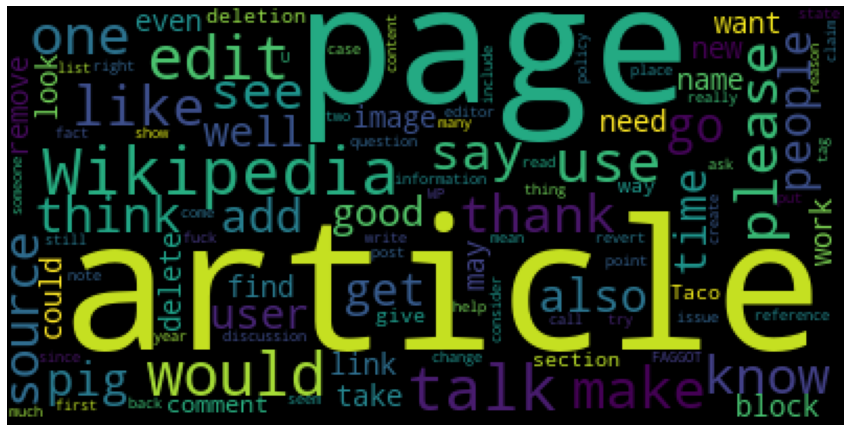

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
stopwords = nltk.corpus.stopwords.words('english')


cloud = WordCloud(stopwords=stopwords, max_words=100, collocations=False).generate(' '.join(data['clean_text']))


plt.figure(figsize=(15,25))
plt.imshow(cloud)
plt.axis('off')
plt.show()

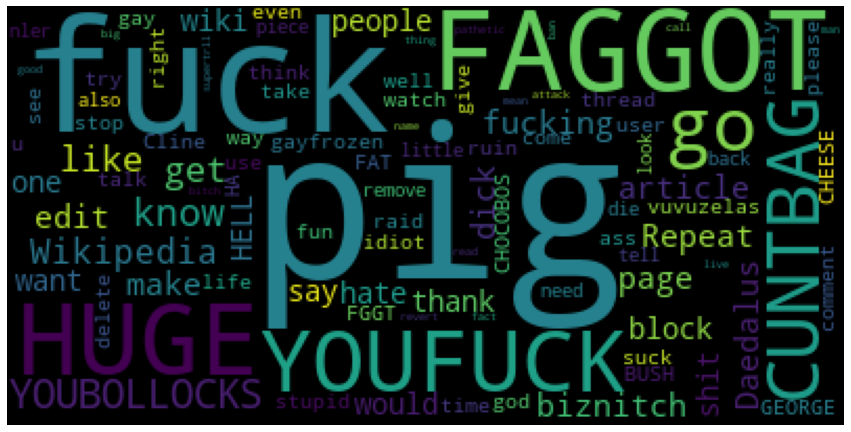

In [18]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
stopwords = nltk.corpus.stopwords.words('english')


cloud = WordCloud(stopwords=stopwords, max_words=100, collocations=False).generate(' '.join(data[data['toxic'] == 1]['clean_text']))


plt.figure(figsize=(15,35))
plt.imshow(cloud)
plt.axis('off')
plt.show()

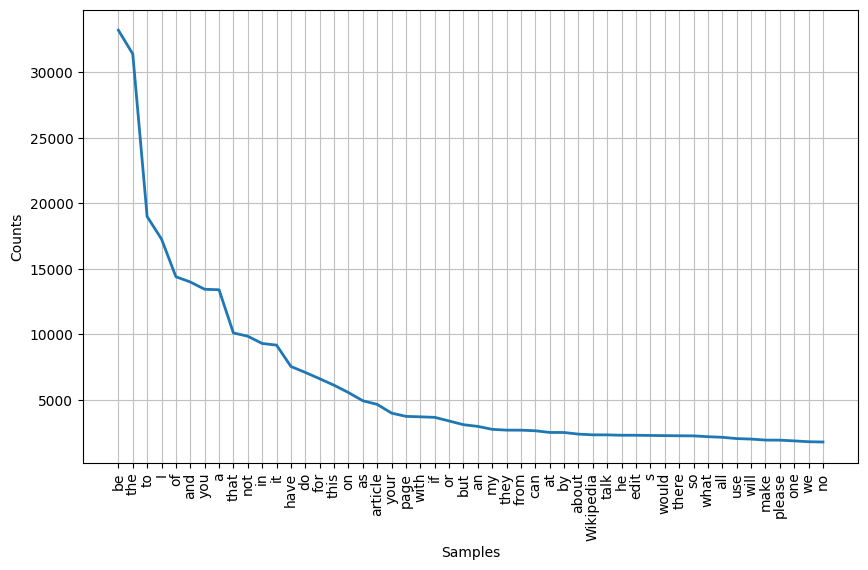

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [12]:
tokens = nltk.tokenize.word_tokenize(' '.join(data['clean_text']))

fdist = FreqDist(tokens)


fdist.most_common(50)
fig = plt.figure(figsize=(10, 6), dpi=100)
fdist.plot(50,cumulative=False)

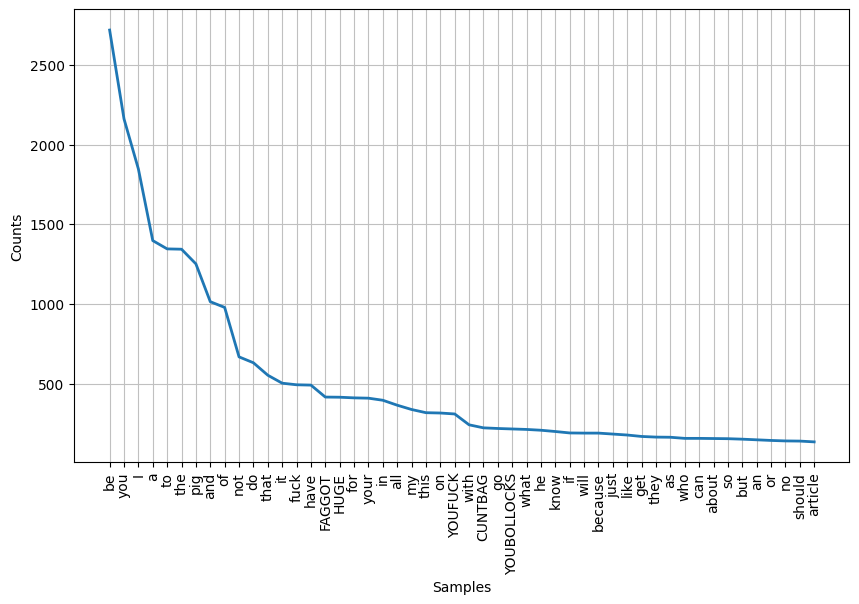

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [14]:
toxic_tokens = nltk.tokenize.word_tokenize(' '.join(data[data['toxic'] == 1]['clean_text']))
toxic_fdist = nltk.FreqDist(toxic_tokens)

fig = plt.figure(figsize=(10, 6), dpi=100)
toxic_fdist.plot(50, cumulative=False)

In [ ]:
counts_toxic = data['toxic'].value_counts()
plt.bar(counts_toxic.index, counts_toxic.values)
plt.xticks([0, 1])
plt.show()

Целевой признак имеет дисбаланс, в процессе работы попробую с ним разобраться

## Подготовка к обучению

In [ ]:
features = data['clean_text']
target = data['toxic']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size= 0.2, stratify = target, random_state = 42)

In [ ]:
# nltk.download('stopwords') 
# stop_words =  set(stopwords('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords) 

In [ ]:
X_train_tf_idf = count_tf_idf.fit_transform(X_train)
X_test_tf_idf = count_tf_idf.transform(X_test)

In [ ]:
X_train_tf_idf

Из текстовых данных сделали матричный вид данных, для токсичных слов применили загруженный словарь

## Обучение моделей

### LR

In [ ]:
model = LogisticRegression(random_state = 42)
model.fit(X_train_tf_idf, y_train)
lr_f1 = cross_val_score(model, 
                                    X_train_tf_idf, 
                                    y_train,
                                    scoring = 'f1', 
                                    cv=3).mean()
print('F1 : {:.4f}'.format(lr_f1))  

In [ ]:
model = LogisticRegression(class_weight='balanced', random_state = 42)
model.fit(X_train_tf_idf, y_train)
lr_bal_f1 = cross_val_score(model, 
                                    X_train_tf_idf, 
                                    y_train,
                                    scoring = 'f1', 
                                    cv=3).mean()
print('F1 : {:.4f}'.format(lr_bal_f1))

### LR GS

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
pipe = Pipeline([

('tfidf', TfidfVectorizer(stop_words=stopwords)),
('model',LogisticRegression(random_state = 42, class_weight = 'balanced'))])


# Задаем список значений гиперпараметров, которые хотим проверить
hyperparams = [{'classifier__penalty': ['l1', 'l2'], 
                'classifier__C': [1.0, 10]}]

# Используем GridSearchCV для поиска наилучших гиперпараметров
clf = GridSearchCV(pipe, hyperparams, scoring='f1')
clf.fit(X_train_tf_idf, y_train)
lr_gs_f1 = clf.best_score_
# Выводим лучшие параметры
print(clf.best_score_)
print('F1 : {:.4f}'.format(lr_gs_f1))

Логистическая регрессия не превысила пороговое значение даже при тюнинге

### CatBoost

Для использования взвешенности классов в модели CatBoost получим их соотношение

In [ ]:
x = data['toxic'].value_counts()[0] / data['toxic'].value_counts()[1]
x

In [ ]:
model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.5,
    l2_leaf_reg=3,
    depth=5,
    eval_metric='F1',
    scale_pos_weight=x, 
    random_seed=42,
    verbose=100
)

model.fit(X_train_tf_idf, y_train)
cb_f1 = cross_val_score(model, 
                                    X_train_tf_idf, 
                                    y_train, 
                                    cv=3, 
                                    scoring='f1').mean()

print('F1 : {:.4f}'.format(cb_f1))

### CatBoost text_features

In [ ]:
train_df = data.sample(frac=0.75, random_state=42).copy()
val_df = data[~data.index.isin(train_df.index)].copy()
test_df, val_df = val_df.sample(frac=0.5, random_state=42), val_df.drop(val_df.sample(frac=0.5, random_state=42).index)
model = CatBoostClassifier(verbose=100, learning_rate=0.7, early_stopping_rounds=200,eval_metric='F1')
model.fit(train_df[['text']], train_df[['toxic']], eval_set=(val_df[['text']], val_df[['toxic']]), text_features=['text'])

In [ ]:
cb_tf_f1 = model.get_best_score()['validation']['F1']
print('F1 : {:.4f}'.format(cb_tf_f1))

#Итог обучения моделей

In [ ]:
#создаю сводную таблицу по показателям F1, времени обучения модели и времени предсказания модели:
index = ['LogisticRegression',
         'LogisticRegression_balanced',
         'LogisticRegression_GridSearch',
         'CatBoostClassifier',
         'CatBoostClassifier_text_features'
         
        ]

table = {'F1 на обучающей выборке': [lr_f1,
                                    lr_bal_f1,
                                    lr_gs_f1,
                                    cb_f1,
                                    cb_tf_f1]}
f1_data = pd.DataFrame(data=table, index=index)

f1_data.sort_values(by='F1 на обучающей выборке', ascending=False)

На необработанных данных только одна модель смогла преодолеть значимый порог метрики f1 в 0.75

Для теста выбрана модель CatBoost с реализованной функцией text_features

## Тест

In [ ]:
#y_test = test_df[['toxic']]
y_pred = clf.predict(X_test_tf_idf)

f1_score_value = f1_score(y_test, y_pred)
print("F1 Score: ", f1_score_value)


## Итог


Для поставленной задачи - классификации токсичности постов - нам был предоставлен массив текстовых данных. В предобработке они не нуждались.

Данные представляли из себя тексты комментариев и их разметка - несет ли текст негативный оттенок или нет.

Данные загружены, обработаны сначала до токенов - предложений, разбитых до составляющих частей и потом лемматизированы- приведены к первоначальной форме слова.

С помощью TfIdf векторайзера предложения приведены в числовой вид - в вид матриц и загружены в модели, где была выбрана лучшая.

Модель CatBoost с реализованной функцией text_features показала себя хорошо и на кроссвалидации и на тесте

Кстати знаешь откуда 42?)

Хорошо, что ты спрашиваешь, потому что я знаю ответ на этот вопрос